In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [23]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.0001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


(3, 32, 32)


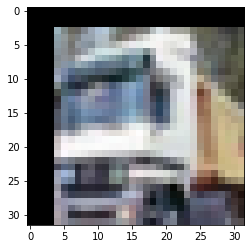

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    print(np.shape(npimg))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print(dataset_train[0])

images, labels = dataset_train[1]

# get some random training images
# dataiter = iter(dataset_train)
# images, labels = dataiter.next()

# show images
imshow(images)

In [28]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [29]:
K = 2
T = 3
N = 2
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

z_array = np.array([-0.81, 0.81])

X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 



(50000, 3072)
(3, 32, 32)


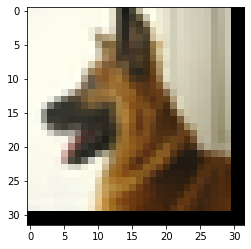

(3, 32, 32)


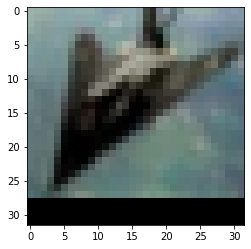

(3, 32, 32)


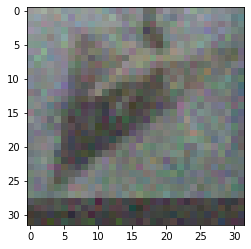

(3, 32, 32)


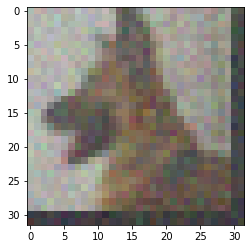

In [35]:
def imshow_np(img):
    img = img / 2 + 0.5     # unnormalize
    
    print(np.shape(img))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
print(np.shape(encoding_input_array_np))

pic_idx=10
tmp_imag = np.reshape(encoding_input_array_np[0+pic_idx,:],(3,32,32))

imshow_np(tmp_imag)

tmp_imag = np.reshape(encoding_input_array_np[25000+pic_idx,:],(3,32,32))

imshow_np(tmp_imag)


tmp_imag = np.reshape(X_tilde[0,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)

tmp_imag = np.reshape(X_tilde[1,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)

In [36]:
K = 2
T = 3
N = 2
sigma = 0.5
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

z_array = np.array([-0.81, 0.81])

X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 



(3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


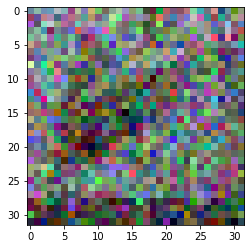

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


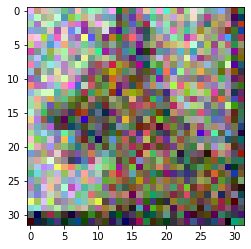

In [37]:
tmp_imag = np.reshape(X_tilde[0,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)

tmp_imag = np.reshape(X_tilde[1,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


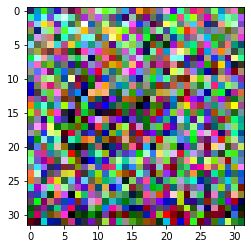

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


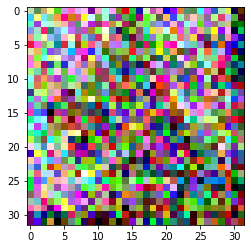

In [38]:
sigma = 1

X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

tmp_imag = np.reshape(X_tilde[0,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)

tmp_imag = np.reshape(X_tilde[1,pic_idx,:],(3,32,32))
imshow_np(tmp_imag)